# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
email_tbl = pd.read_csv('email_table.csv', on_bad_lines='skip')
email_opened_tbl = pd.read_csv('email_opened_table.csv', on_bad_lines='skip')
link_clicked_tbl = pd.read_csv('link_clicked_table.csv', on_bad_lines='skip')


In [3]:
email_tbl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [4]:
email_opened_tbl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  10345 non-null  int64
dtypes: int64(1)
memory usage: 80.9 KB


In [5]:
link_clicked_tbl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  2119 non-null   int64
dtypes: int64(1)
memory usage: 16.7 KB


Q. What percentage of users opened the email and what percentage clicked on the link
within the email?

In [6]:
# Calculate the percentage of opened and clicked emails
percent_opened = (email_tbl[email_tbl.email_id.isin(email_opened_tbl.email_id)].shape[0] / float(email_tbl.shape[0])) * 100
percent_clicked = (email_tbl[email_tbl.email_id.isin(link_clicked_tbl.email_id)].shape[0] / float(email_tbl.shape[0])) * 100

# Print the results (Python 3.x syntax)
print("Percent opened: {0:.2f}%".format(percent_opened))
print("Percent clicked: {0:.2f}%".format(percent_clicked))


Percent opened: 10.35%
Percent clicked: 2.12%


Q. The VP of marketing thinks that it is stupid to send emails to a random subset and in a
random way. Based on all the information you have about the emails that were sent, can
you build a model to optimize in future email campaigns to maximize the probability of
users clicking on the link inside the email?

{'whiskers': [<matplotlib.lines.Line2D at 0x7ab842bad590>,
 'caps': [<matplotlib.lines.Line2D at 0x7ab80a87ee50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ab80b7d7ad0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ab80a888710>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ab80a889310>],
 'means': []}

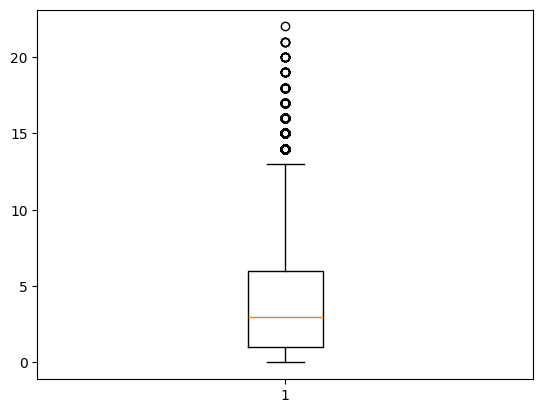

In [7]:
# Create a boxplot of past user purchases
plt.boxplot(email_tbl.user_past_purchases)

In [8]:
# Remove outliers
non_outliers = email_tbl[email_tbl.user_past_purchases < 12]

In [9]:
# Add a 'link_clicked' column to the dataframe
clicked_emails = set(link_clicked_tbl.email_id)
non_outliers['link_clicked'] = non_outliers.email_id.apply((lambda x: 1 if x in clicked_emails else 0))

<ipython-input-9-2586437ec807>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers['link_clicked'] = non_outliers.email_id.apply((lambda x: 1 if x in clicked_emails else 0))


In [10]:
non_outliers.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,link_clicked
0,85120,short_email,personalized,2,Sunday,US,5,0
1,966622,long_email,personalized,12,Sunday,UK,2,1
2,777221,long_email,personalized,11,Wednesday,US,2,0
3,493711,short_email,generic,6,Monday,UK,1,0
4,106887,long_email,generic,14,Monday,US,6,0


In [11]:
non_outliers.user_country.value_counts(normalize=True)

,proportion
user_country,
US,0.600942
UK,0.199662
FR,0.099754
ES,0.099642


In [12]:
# Over 90% of the user base is in the US and UK. For now, we'll simplify the problem and focus only on users in the US and UK.
us_uk_emails = non_outliers[non_outliers.user_country.isin(['US','UK'])]

In [13]:
# Create a binary column 'country_US' to indiciate if the user is in the US or UK
us_uk_emails['country_US'] = us_uk_emails.user_country.apply((lambda x: 1 if x == 'US' else 0))

<ipython-input-13-a8c2658bf433>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_uk_emails['country_US'] = us_uk_emails.user_country.apply((lambda x: 1 if x == 'US' else 0))


In [14]:
# Create a binary column for the email text. Value is 1 for short_emails, 0 for long emails
us_uk_emails['is_short'] = us_uk_emails.email_text.apply((lambda x: 1 if x == 'short_email' else 0))

<ipython-input-14-5756fef582e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_uk_emails['is_short'] = us_uk_emails.email_text.apply((lambda x: 1 if x == 'short_email' else 0))


In [15]:
# Create a binary column for email version. Value is 1 for generic emails, 0 for personalized emails
us_uk_emails['is_generic'] = us_uk_emails.email_version.apply((lambda x: 1 if x == 'generic' else 0))

<ipython-input-15-e863556a6bf3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_uk_emails['is_generic'] = us_uk_emails.email_version.apply((lambda x: 1 if x == 'generic' else 0))


In [16]:
us_uk_emails[us_uk_emails['link_clicked'] == 1].hour.value_counts(normalize=True)

,proportion
hour,
10,0.107761
9,0.105528
11,0.095477
12,0.078169
8,0.077052
7,0.068677
6,0.060302
5,0.054160
13,0.053043


In [17]:
# Very few people who click on the email links do so during the evening hours. We'll therefore lump these variables into a
# a category called EVENING to reduce the number of dummy variables to create for the model.
evening_hours = [19,20,21,22,23,24]
us_uk_emails['hour_sent'] = us_uk_emails.hour.apply((lambda x: 'EVENING' if x in evening_hours else str(x)))

<ipython-input-17-64849effa637>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_uk_emails['hour_sent'] = us_uk_emails.hour.apply((lambda x: 'EVENING' if x in evening_hours else str(x)))


In [18]:
# Create dummy variables for the weekday and hour columns
weekday_dummies = pd.get_dummies(us_uk_emails.weekday,prefix='weekday').drop('weekday_Sunday',axis=1)
hour_dummies = pd.get_dummies(us_uk_emails.hour_sent,prefix='hour_sent').drop('hour_sent_EVENING',axis=1)

In [19]:
# Create the feature matrix
df = us_uk_emails[['user_past_purchases','is_short','is_generic','link_clicked']]
df = df.join(weekday_dummies)
df = df.join(hour_dummies)
y = df.pop('link_clicked').values
X = df.values

In [20]:
'''
Since a very tiny percentage of users who clicked the link in the email, we will undersample the majority class to balance
the dataset.
'''
def undersample(X,y):
    majority_X = X[y == 0]
    majority_y = y[y == 0]
    minority_y = y[y == 1]
    minority_X = X[y == 1]
    minority_size = y[y == 1].shape[0]

    inds = np.arange(minority_size)
    samples = np.random.choice(inds, minority_size,replace=False)

    undersampled_X = np.concatenate((majority_X[samples],minority_X), axis=0)
    undersampled_y = np.concatenate((majority_y[samples],minority_y), axis=0)
    return (undersampled_X, undersampled_y)

In [21]:
# Split the data into a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1)

In [22]:
# Undersample the training data to balance the classes
X_sub,y_sub = undersample(X_train,y_train)

In [23]:
# Train and tune a random forest classifer
rf_params = {'n_estimators':[20,30,40,50],
             'criterion':['gini','entropy'],
             'max_features':['auto','log2'],
             'min_samples_leaf':[1,2,5,10,11,12,13,14,15],
             'min_samples_split':[2, 3, 5, 7,10]}
rf_clf = GridSearchCV(RandomForestClassifier(),rf_params, scoring = 'roc_auc')
rf_clf.fit(X_sub,y_sub)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1800 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1800 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/u

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10, 11, 12, 13, 14, 15],
                         'min_samples_split': [2, 3, 5, 7, 10],
                         'n_estimators': [20, 30, 40, 50]},
             scoring='roc_auc')

In [24]:
rf_clf.best_params_

{'criterion': 'gini',
 'max_features': 'log2',
 'min_samples_leaf': 13,
 'min_samples_split': 7,
 'n_estimators': 40}

In [25]:
rf_clf.best_score_

np.float64(0.7155908632160594)

In [26]:
# Train and tune a logistic regression classifer
lr_params = {'C':[0.1,0.2, 0.3, 0.4]}
lr_clf = GridSearchCV(LogisticRegression(),lr_params,scoring='roc_auc')
lr_clf.fit(X_sub,y_sub)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.2, 0.3, 0.4]}, scoring='roc_auc')

In [27]:
lr_clf.best_params_

{'C': 0.1}

In [28]:
lr_clf.best_score_

np.float64(0.7083797012357319)

In [29]:
# Train and tune a Gradient Boosting classifer
gbc_params = {'learning_rate':[0.1,0.2,0.3,0.4],
              'n_estimators':[100,200],
              'min_samples_leaf':[1,5,7,8],
              'min_samples_split':[2, 3, 5, 7,10],
              'max_features':['auto','log2']
             }
gbc_clf = GridSearchCV(GradientBoostingClassifier(),gbc_params,scoring='roc_auc')
gbc_clf.fit(X_sub,y_sub)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
800 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
800 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [1, 5, 7, 8],
                         'min_samples_split': [2, 3, 5, 7, 10],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [30]:
gbc_clf.best_params_

{'learning_rate': 0.1,
 'max_features': 'log2',
 'min_samples_leaf': 8,
 'min_samples_split': 10,
 'n_estimators': 100}

In [31]:
gbc_clf.best_score_

np.float64(0.7153246060589401)

In [33]:
# Train and tune a Support Vector classifer
svc_params = {'kernel':['rbf','sigmoid','linear','poly'],
              'C':[0.1,0.5,1,5,10],
              'degree':[1,3,5],
              'coef0':[0.5,0.6,0.7]
             }
svc_clf = GridSearchCV(SVC(),svc_params,scoring='roc_auc')
svc_clf.fit(X_sub,y_sub)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 5, 10], 'coef0': [0.5, 0.6, 0.7],
                         'degree': [1, 3, 5],
                         'kernel': ['rbf', 'sigmoid', 'linear', 'poly']},
             scoring='roc_auc')

In [34]:
svc_clf.best_params_

{'C': 1, 'coef0': 0.5, 'degree': 1, 'kernel': 'rbf'}

In [35]:
svc_clf.best_score_

np.float64(0.7091452410458816)

In [38]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, recall_score, auc

# Logistic Regression
lr = LogisticRegression(C=0.1)
lr.fit(X_sub, y_sub)
lr_pred = lr.predict(X_val)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_val, lr_pred)
lr_recall = recall_score(y_val, lr_pred)
lr_auc = auc(lr_fpr, lr_tpr)

# Random Forest Classifier
rf = RandomForestClassifier(criterion='entropy',
                            max_features='sqrt',  # Changed from 'auto' to 'sqrt'
                            min_samples_leaf=12,
                            min_samples_split=7,
                            n_estimators=40)
rf.fit(X_sub, y_sub)
rf_pred = rf.predict(X_val)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val, rf_pred)
rf_recall = recall_score(y_val, rf_pred)
rf_auc = auc(rf_fpr, rf_tpr)

# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(learning_rate=0.1,
                                 max_features='log2',
                                 min_samples_leaf=5,
                                 min_samples_split=2,
                                 n_estimators=100)
gbc.fit(X_sub, y_sub)
gbc_pred = gbc.predict(X_val)
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_val, gbc_pred)
gbc_recall = recall_score(y_val, gbc_pred)
gbc_auc = auc(gbc_fpr, gbc_tpr)

# Support Vector Classifier
svc = SVC(C=1, coef0=0.6, degree=1, kernel='poly')
svc.fit(X_sub, y_sub)
svc_pred = svc.predict(X_val)
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_val, svc_pred)
svc_recall = recall_score(y_val, svc_pred)
svc_auc = auc(svc_fpr, svc_tpr)

In [39]:
# Assuming lr_auc, lr_recall, rf_auc, rf_recall, gbc_auc, gbc_recall, svc_auc, and svc_recall have been defined
print("Logistic Regression (AUC, Recall): ({0:.2f}, {1:.2f})".format(lr_auc, lr_recall))
print("Random Forest (AUC, Recall): ({0:.2f}, {1:.2f})".format(rf_auc, rf_recall))
print("Gradient Boosting Classifier (AUC, Recall): ({0:.2f}, {1:.2f})".format(gbc_auc, gbc_recall))
print("Support Vector Classifier (AUC, Recall): ({0:.2f}, {1:.2f})".format(svc_auc, svc_recall))


Logistic Regression (AUC, Recall): (0.61, 0.58)
Random Forest (AUC, Recall): (0.63, 0.69)
Gradient Boosting Classifier (AUC, Recall): (0.62, 0.68)
Support Vector Classifier (AUC, Recall): (0.62, 0.60)


In [40]:
# THe Random Forest classifer appears to be the best. Let's check out it's confusion matrix.
confusion_matrix(y_val,rf_pred)

array([[4330, 3308],
       [  57,  127]])

Potential Enhancements

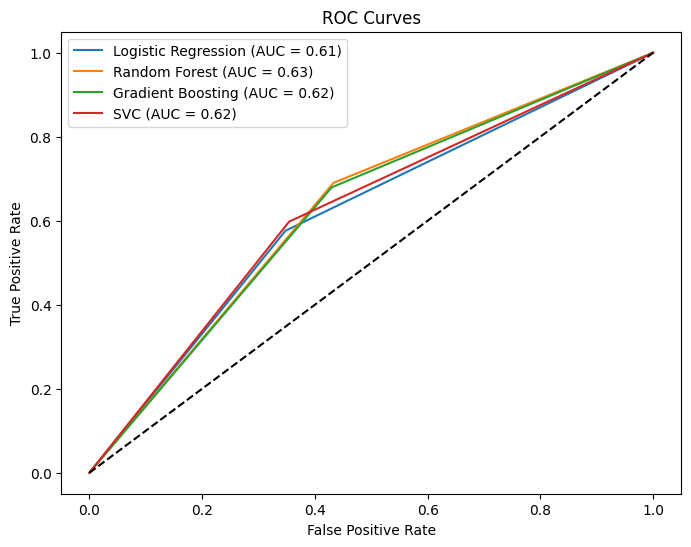

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(gbc_fpr, gbc_tpr, label=f'Gradient Boosting (AUC = {gbc_auc:.2f})')
plt.plot(svc_fpr, svc_tpr, label=f'SVC (AUC = {svc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

Confusion Matrix Heatmap (for Model Comparison)

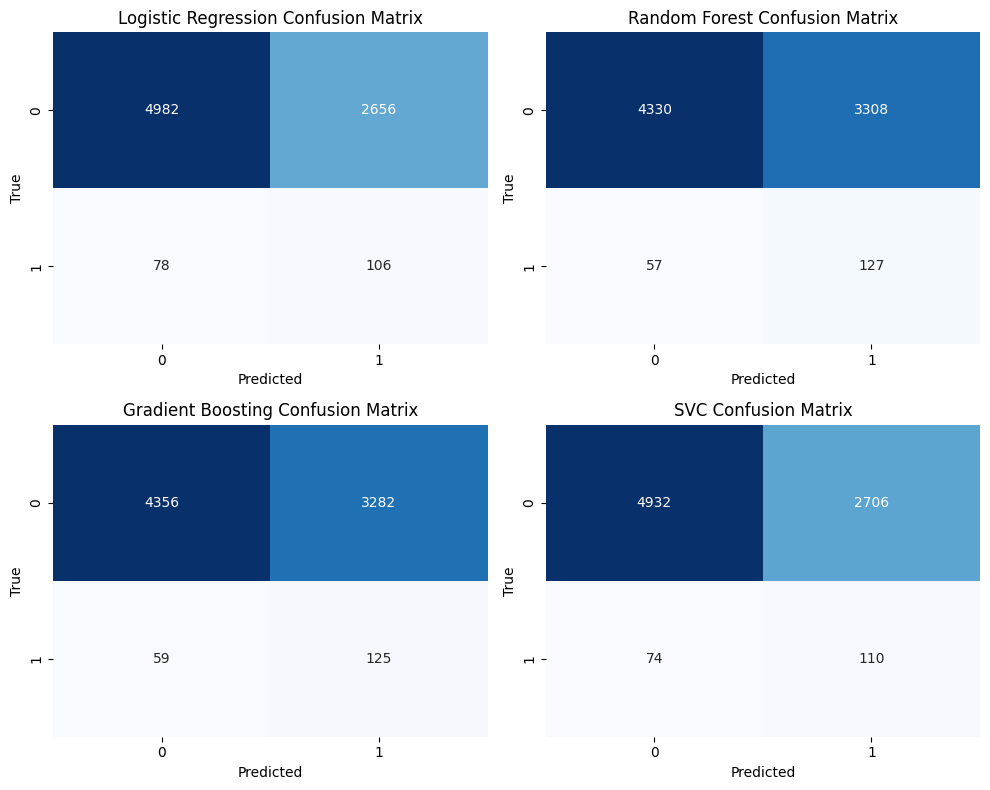

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
models = {'Logistic Regression': lr_pred, 'Random Forest': rf_pred,
          'Gradient Boosting': gbc_pred, 'SVC': svc_pred}

plt.figure(figsize=(10, 8))
for i, (name, pred) in enumerate(models.items(), 1):
    cm = confusion_matrix(y_val, pred)
    plt.subplot(2, 2, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()

Precision-Recall Curve

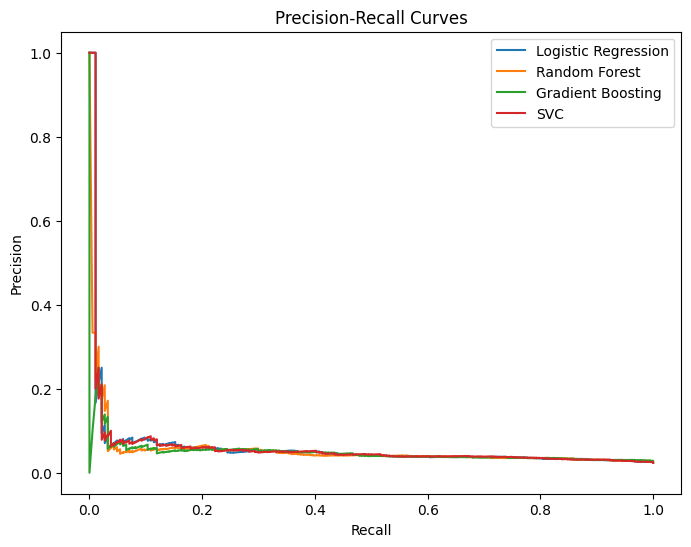

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curves
lr_precision, lr_recall, _ = precision_recall_curve(y_val, lr.predict_proba(X_val)[:, 1])
rf_precision, rf_recall, _ = precision_recall_curve(y_val, rf.predict_proba(X_val)[:, 1])
gbc_precision, gbc_recall, _ = precision_recall_curve(y_val, gbc.predict_proba(X_val)[:, 1])
svc_precision, svc_recall, _ = precision_recall_curve(y_val, svc.decision_function(X_val))

plt.figure(figsize=(8, 6))
plt.plot(lr_recall, lr_precision, label='Logistic Regression')
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.plot(gbc_recall, gbc_precision, label='Gradient Boosting')
plt.plot(svc_recall, svc_precision, label='SVC')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

Feature Importance Bar Plot (for Random Forest and Gradient Boosting)

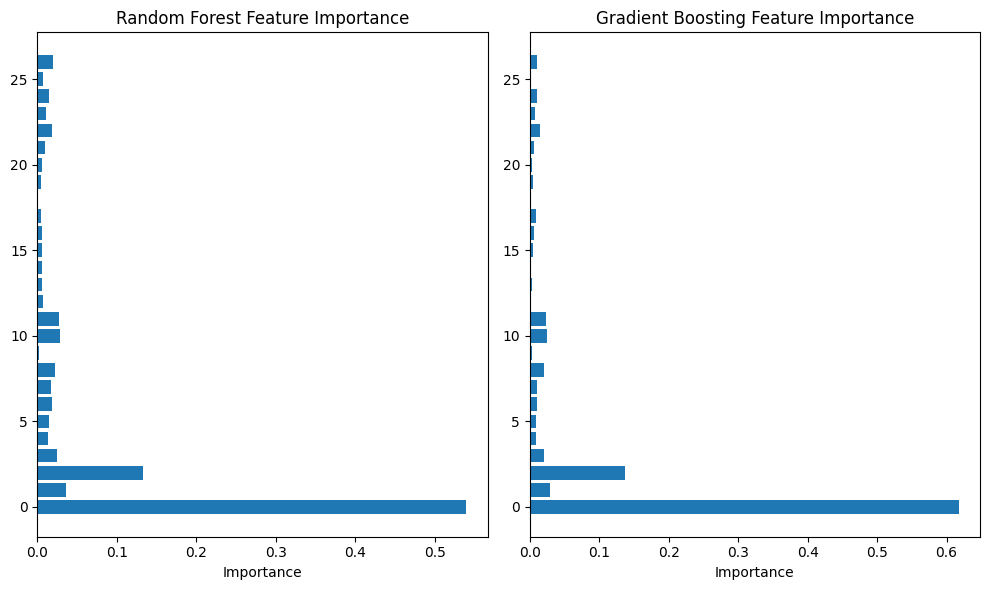

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_sub has column names; otherwise, use indices
feature_names = X_sub.columns if hasattr(X_sub, 'columns') else np.arange(X_sub.shape[1])

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.barh(feature_names, rf.feature_importances_)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')

plt.subplot(1, 2, 2)
plt.barh(feature_names, gbc.feature_importances_)
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

Recall vs. Threshold Plot

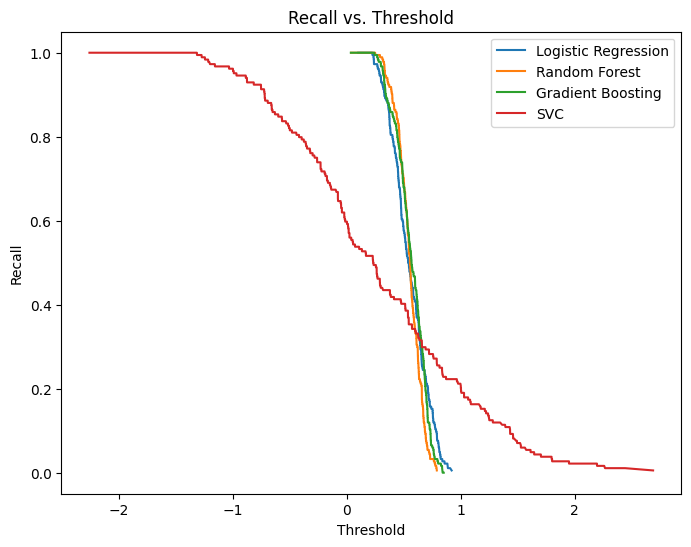

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Compute recall vs. threshold
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_val, lr.predict_proba(X_val)[:, 1])
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_val, rf.predict_proba(X_val)[:, 1])
gbc_precision, gbc_recall, gbc_thresholds = precision_recall_curve(y_val, gbc.predict_proba(X_val)[:, 1])
svc_precision, svc_recall, svc_thresholds = precision_recall_curve(y_val, svc.decision_function(X_val))

plt.figure(figsize=(8, 6))
plt.plot(lr_thresholds, lr_recall[:-1], label='Logistic Regression')
plt.plot(rf_thresholds, rf_recall[:-1], label='Random Forest')
plt.plot(gbc_thresholds, gbc_recall[:-1], label='Gradient Boosting')
plt.plot(svc_thresholds, svc_recall[:-1], label='SVC')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs. Threshold')
plt.legend()
plt.show()

4. Prediction Probability Distribution

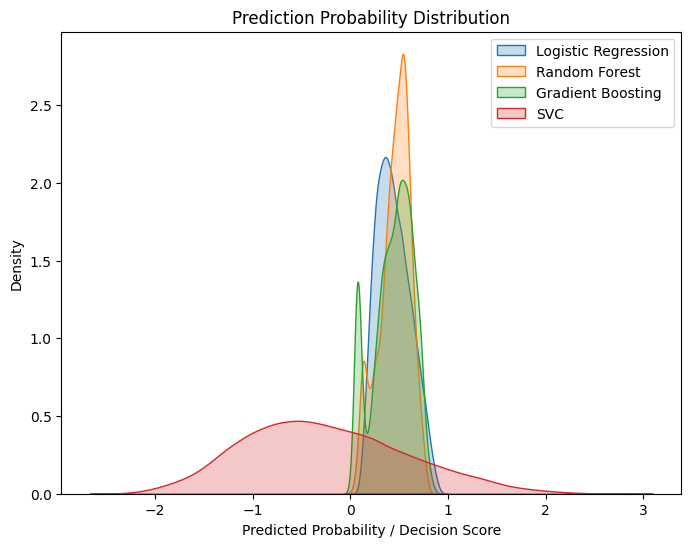

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.kdeplot(lr.predict_proba(X_val)[:, 1], label='Logistic Regression', fill=True)
sns.kdeplot(rf.predict_proba(X_val)[:, 1], label='Random Forest', fill=True)
sns.kdeplot(gbc.predict_proba(X_val)[:, 1], label='Gradient Boosting', fill=True)
# SVC uses decision_function instead of predict_proba
sns.kdeplot(svc.decision_function(X_val), label='SVC', fill=True)
plt.xlabel('Predicted Probability / Decision Score')
plt.ylabel('Density')
plt.title('Prediction Probability Distribution')
plt.legend()
plt.show()

Q. By how much do you think your model would improve click through rate ( defined as # of
users who click on the link / total users who received the email). How would you test
that?  
  
**I would expect at least a 1% improvement in click through rate. I would use an A/B test to test this assumption. I would randomly split the users into a control group and a test group and launch another email campaign for both groups. Emails will be sent out in a random way in the first group, and the model will be used to target the emails to users in the test group. At the end of the campaign, I will run a statistical test for significance.
**

Q. Did you find any interesting pattern on how the email campaign performed for different
segments of users? Explain.

** I noticed that the ideal times for users who click on the link in the email vary by country and by day of the week. See the bar plots below. **

In [41]:
def plot_hourly_counts(ax, df, atitle):
    email_hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    email_counts = df.groupby(['hour','link_clicked'])['email_id'].count().to_dict()

    counts_clicked = []
    counts_noclicked = []
    bar_width = 0.35
    ind = np.arange(len(email_hours))

    for e in email_hours:
        if (e,1) in email_counts:
            counts_clicked.append(email_counts[(e,1)])
        else:
            counts_clicked.append(0)
        if (e,0) in email_counts:
            counts_noclicked.append(email_counts[(e,0)])
        else:
            counts_noclicked.append(0)
    ax.bar(ind,counts_clicked,bar_width,color='r',label='clicked')
    ax.bar(ind+bar_width,counts_noclicked,bar_width,color='g',label='not clicked')
    ax.set_title(atitle)

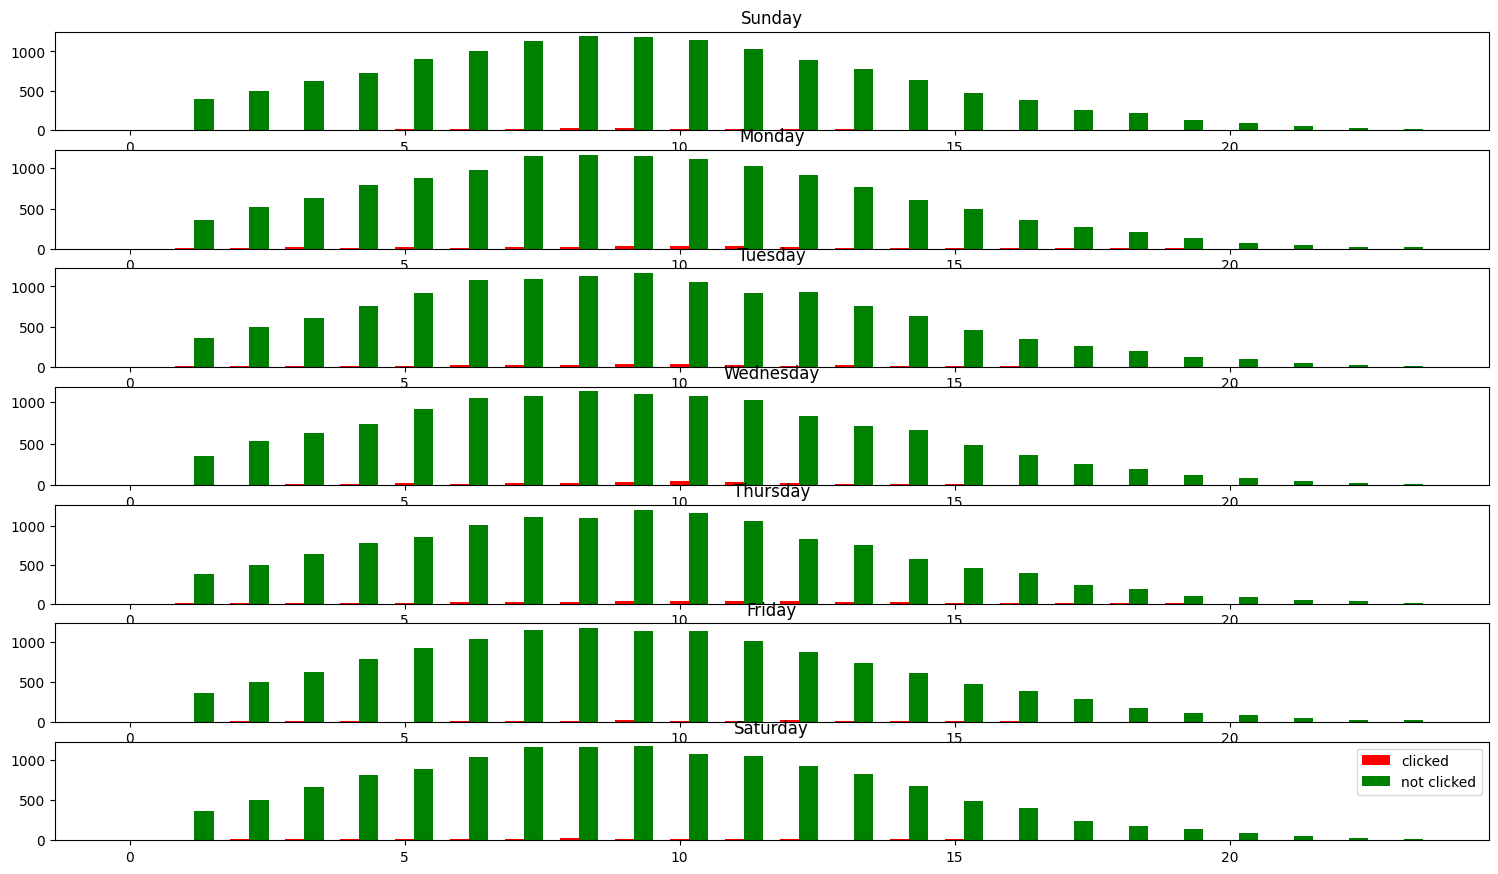

In [42]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
for i in range(7):
    df = non_outliers[non_outliers.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()

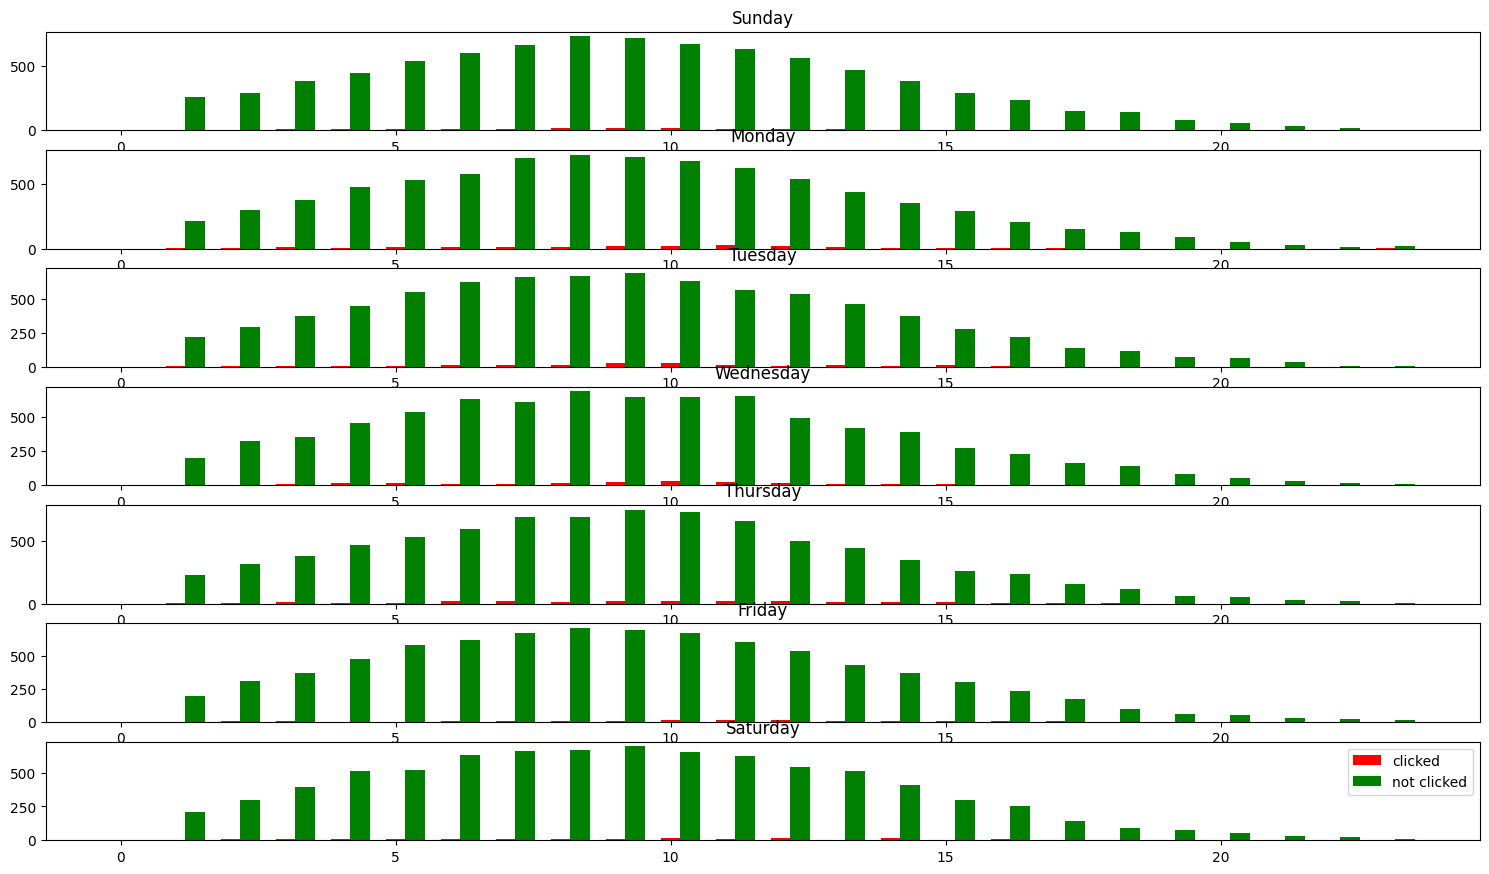

In [43]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
us_emails = non_outliers[non_outliers.user_country == 'US']
for i in range(7):
    df = us_emails[us_emails.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()

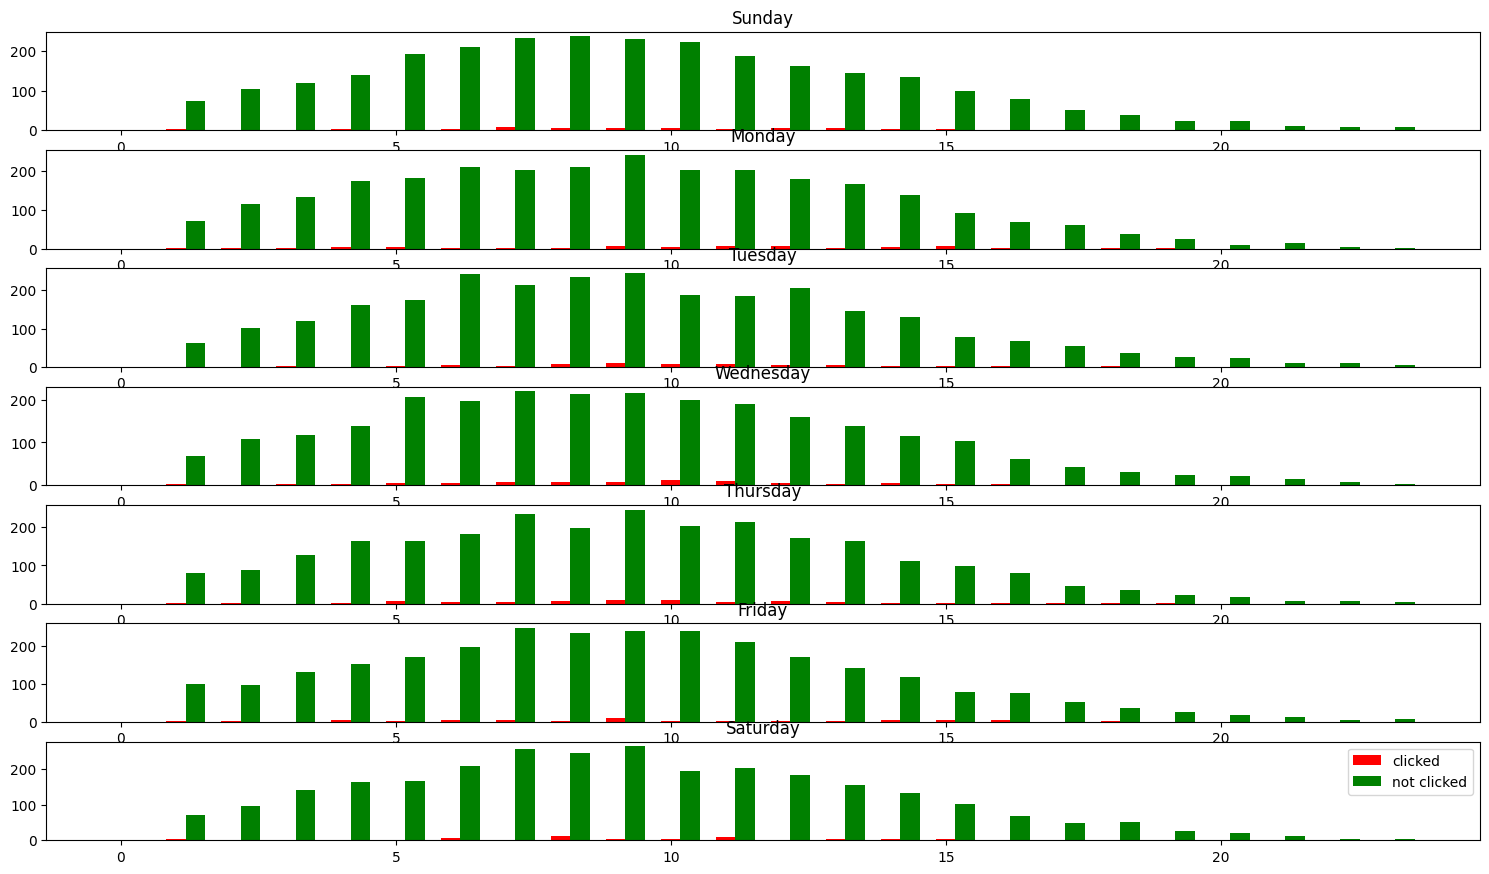

In [44]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
us_emails = non_outliers[non_outliers.user_country == 'UK']
for i in range(7):
    df = us_emails[us_emails.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()

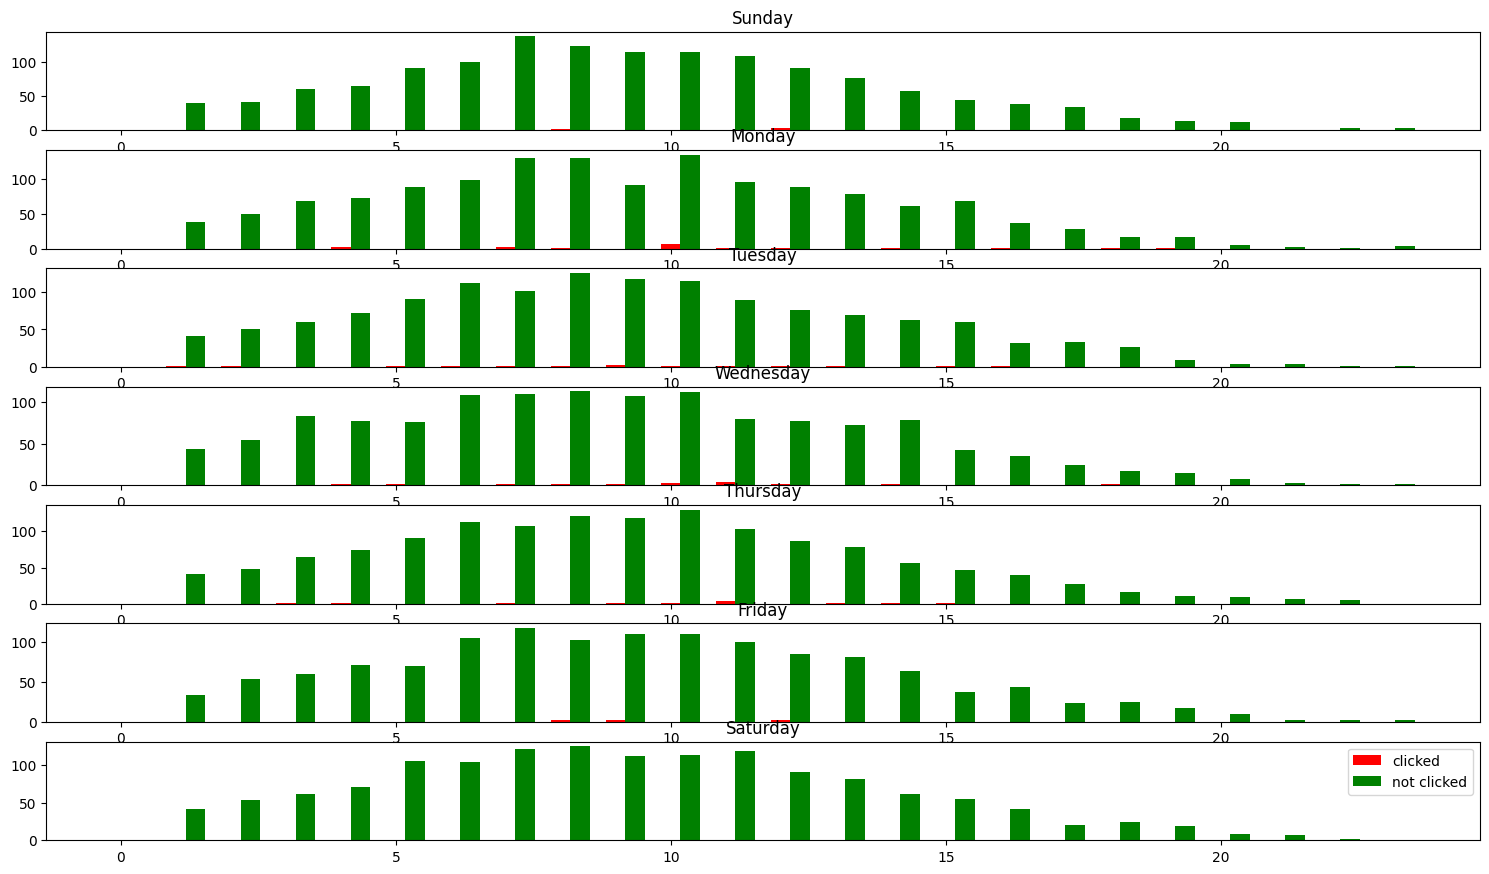

In [45]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
us_emails = non_outliers[non_outliers.user_country == 'ES']
for i in range(7):
    df = us_emails[us_emails.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()

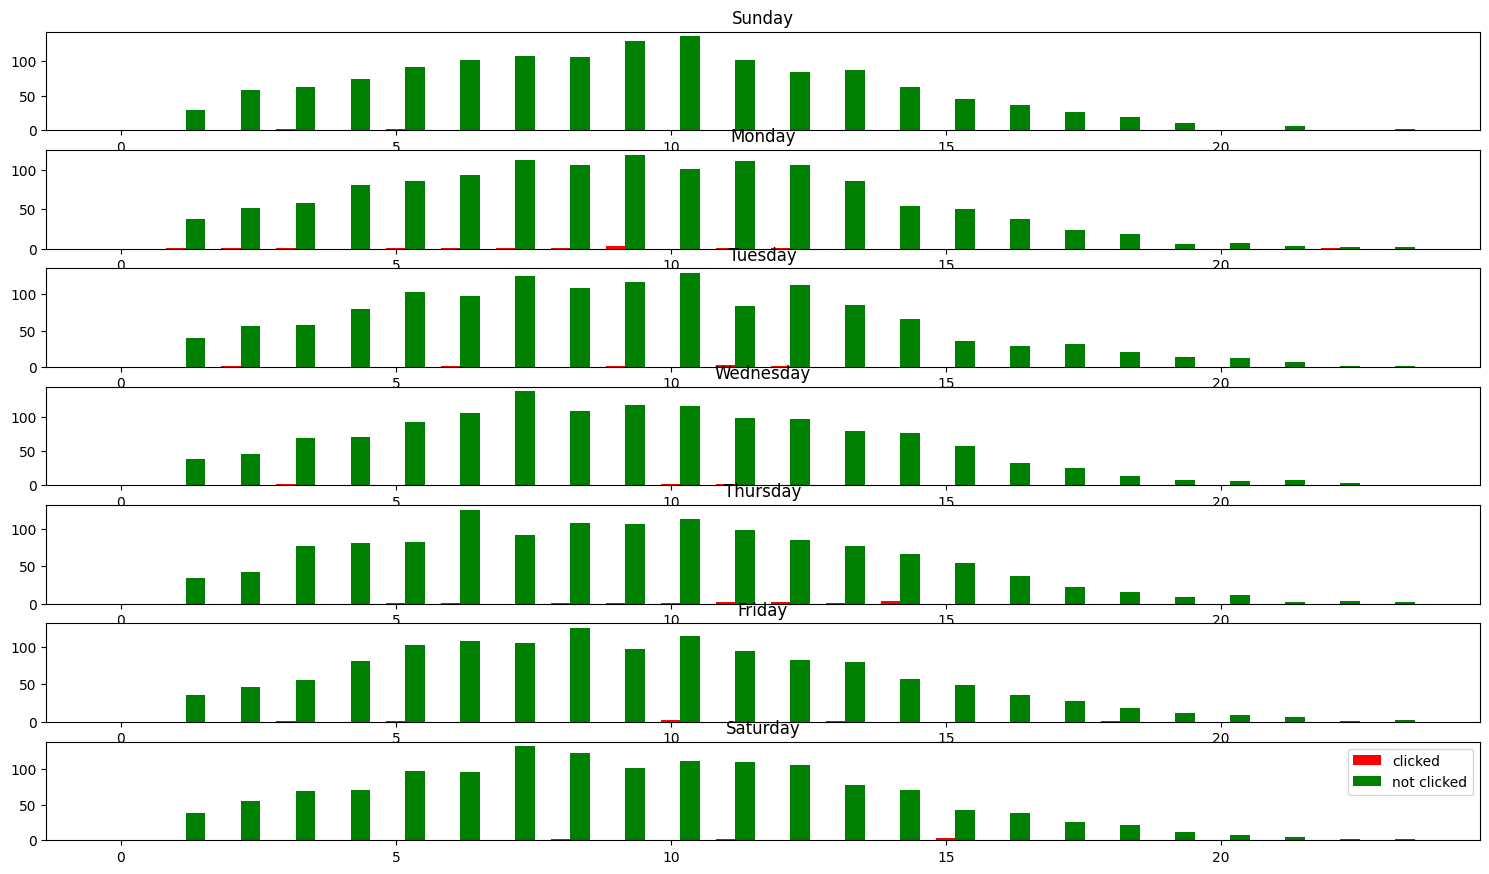

In [46]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
us_emails = non_outliers[non_outliers.user_country == 'FR']
for i in range(7):
    df = us_emails[us_emails.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()